<div style="text-align: center; font-size: 40px;">
    <strong>Election Data Analysis</strong>
</div>


## **Introduction**
This dataset provides comprehensive candidate-level data for elections to the lower houses of India's national and state legislatures, specifically the Lok Sabha and Vidhan Sabhas, spanning the years 1977 to 2015. Each row represents a candidate who contested elections in a particular constituency during a given year.

- The dataset includes detailed variables such as state names, election years, constituency details, candidate demographics, party affiliations, and election outcomes. Key attributes include:
    - **State Information:** Name of the state (st_name).
    - **Election Details:** Year of the general election (Year), parliamentary constituency number (pc_no), and - - constituency name (pc_name).
    - **Constituency Type:** Reservation status of the constituency (pc_type), categorized as General, SC, or ST.
    - **Candidate Details:** Name (cand_name) and gender (cand_sex).
    - **Party Details:** Full party name (partyname) and abbreviation (partyabbre).
    - **Voting Metrics:** Total votes received by the candidate (totvotpoll) and the number of registered voters in the constituency (electors).


- This dataset serves as a valuable resource for analyzing electoral trends, candidate participation, voter behavior, and political dynamics over nearly four decades.
>


### **Importing the Libraries**


In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

## **DB Schema Diagram**
- The ER diagram represents the DB schema followed for the analysis showing relations between various entities.

<div style="text-align: center;">
    <img src="election-schema.jpg" width="900"/>
</div>

- The diagram represents a relational database schema for managing Indian election data, covering Lok Sabha (national) and Vidhan Sabha (state) elections.
    - **National Master (nationalmaster):** Stores candidate-level data for Lok Sabha elections, linked to lkconstituency, loksabhastate, and lkparty.
    - **State Master (statemaster):** Stores candidate-level data for Vidhan Sabha elections, linked to vdconstituency, vidhansabhastate, and vdparty.
    - **Constituency Tables (lkconstituency & vdconstituency):** Contain constituency details such as ID, name, and reservation type.
    - **State Tables (loksabhastate & vidhansabhastate):** Define states for national and state elections.
    - **Party Tables (lkparty & vdparty):** Store political party details for both elections.

- This schema enables efficient organization, integration, and analysis of national and state election data.


### **DB Connection Function**

Acts as the bridge for connecting to the database and executing queries.


In [2]:
def get_alchemy_engine():
    """
    Creates and returns an SQLAlchemy engine using the database settings.
    """
    db_settings = {
        "ENGINE": "django.db.backends.postgresql",  # Database engine
        
        "NAME": "ElectionDB",                     # Database name
        "USER": "postgres",                        # Username
        "PASSWORD": "password@123",                # Password with special characters
        "HOST": "localhost",                       # Host address
        "PORT": "5432",                            # Port
    }
    
    # URL-encode the password to handle special characters
    encoded_password = quote_plus(db_settings['PASSWORD'])
    
    # Construct the SQLAlchemy connection URL
    connection_url = (
        f"postgresql://{db_settings['USER']}:{encoded_password}@"
        f"{db_settings['HOST']}:{db_settings['PORT']}/{db_settings['NAME']}"
    )
    
    # Create and return the SQLAlchemy engine
    engine = create_engine(connection_url)
    return engine

def fetch_data(query):
    """
    Fetches data from the PostgreSQL database using Pandas.
    :param query: SQL query string
    :return: Pandas DataFrame with query results
    """
    engine = get_alchemy_engine()
    
    # Use Pandas to execute the query and fetch data into a DataFrame
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)

    if engine:
        engine.dispose()
        # print("Engine connection closed.")
        
    return df

## **Data Feature Description**
For the dataset considered in the analysis following is the detailed overview for the same, representing important info for each feature.
                                                                                                                       

In [3]:
descQuery = '''
    SELECT
        UPPER(column_name) AS "Feature Name",
        UPPER(data_type) AS "Feature Type",
        CASE 
            WHEN data_type IN ('character varying', 'text') THEN 'VARCHAR'
            WHEN data_type IN ('integer', 'bigint', 'smallint') THEN 'INTEGER'
            WHEN data_type = 'date' THEN 'DATE'
            ELSE data_type
        END AS "Feature DTYPE",
        (SELECT COUNT(*) 
         FROM nationalmaster 
         WHERE column_name IS NULL) AS "Total Null Values"
    FROM
        information_schema.columns
    WHERE
        table_name = 'nationalmaster';
'''
data = fetch_data(descQuery)
data  

,Feature Name,Feature Type,Feature DTYPE,Total Null Values
0,ELECTIONYEAR,INTEGER,INTEGER,0
1,PCID,INTEGER,INTEGER,0
2,PRID,INTEGER,INTEGER,0
3,TOTVOTPOLL,INTEGER,INTEGER,0
4,ELECTORS,INTEGER,INTEGER,0
5,LKSID,INTEGER,INTEGER,0
6,CAND_SEX,CHARACTER VARYING,VARCHAR,0
7,CAND_NAME,CHARACTER VARYING,VARCHAR,0


## **Exploratory Data Analysis**

In [4]:
yearQuery = '''
    
    WITH totalELectors AS (
    	SELECT 
    		t1.electionyear,
    		SUM(t1.electors) AS electors
    	FROM (
    		SELECT 
    			DISTINCT ON (nm.electionyear, nm.pcid) 
    		    nm.electionyear, 
    		    nm.pcid, 
    		    nm.electors
    		FROM 
    			nationalmaster nm
    	) AS t1
    	GROUP BY 
    		t1.electionyear
    )

    SELECT 
    	nm.electionyear,
    	-- STATE --
    	COUNT(DISTINCT nm.lksid) AS totalStates,
    	-- CONSTITUENCY --
    	COUNT(DISTINCT lc.pcid ) AS totalCT,
    	COUNT(
    	DISTINCT 
    	CASE 
    		WHEN lc.pc_type = 'GEN' THEN nm.pcid ELSE 0 
    	END
    	) AS genCT,
    	COUNT(
    	DISTINCT 
    	CASE 
    		WHEN lc.pc_type = 'SC' THEN nm.pcid ELSE 0 
    	END
    	) AS scCT,
    	COUNT(
    	DISTINCT
    	CASE 
    		WHEN lc.pc_type = 'ST' THEN nm.pcid ELSE 0 
    	END
    	) AS stCT,
    	-- CANDIDATE --
    	COUNT(*) AS totalCandidates,
    	SUM(
    	CASE 
    		WHEN nm.cand_sex = 'M' THEN 1 ELSE 0 
    	END
    	) AS male,
    	SUM(
    	CASE 
    		WHEN nm.cand_sex = 'F' THEN 1 ELSE 0 
    	END
    	) AS female,
    	SUM(
    	CASE 
    		WHEN nm.cand_sex = 'O' THEN 1 ELSE 0 
    	END
    	) AS others,
    	COUNT (DISTINCT prid) AS partyCount,
    	SUM(totvotpoll) AS totvotpoll ,
    	te.electors,
    	ROUND(((CAST(SUM(totvotpoll) AS DECIMAL(15,2)) / CAST(te.electors AS DECIMAL(15,2))) * 100 ),1) AS avgTurnout
    --*
    FROM 
    	nationalmaster nm
    LEFT JOIN 
    	lkconstituency lc ON nm.pcid = lc.pcid 
    LEFT JOIN 
    	totalELectors AS te ON nm.electionyear  = te.electionyear
    GROUP BY 
    	nm.electionyear ,
    	te.electors
'''
yearData = fetch_data(yearQuery)
yearData  
df = yearData

In [19]:
def plotTwoCharts(df, chartParams):
    # print(df.columns)
    """
    Function to plot two charts side by side with different chart types (line, scatter, bar, pie, histogram).
    Parameters:
    df (DataFrame): The dataframe containing the data
    chartParams (dict): Dictionary containing chart details
    """
    totalCharts = len(chartParams['chartData'])
    rows = (totalCharts + 1) // 2  # Calculate rows for the fixed 2-column layout

    # Create subplots
    fig, axes = plt.subplots(rows, 2, figsize=(13, 5 * rows))
    axes = axes.flatten()  # Flatten to simplify indexing

    for chart in range(totalCharts):
        chartDetails = chartParams['chartData'][chart]
        # print(c?hartDetails)
        chartType = chartDetails['type']
        xvalue = chartDetails['xCol']
        yvalues = chartDetails['yCol']
        lvalue = chartDetails.get('legend', None)  # Use .get to handle optional keys

        sns.set_style("darkgrid")
        # print(xvalue)
        if chartType == 'line':
            if lvalue:  # If 'legend' is specified, restructure the data for grouped plotting
                plot_df = pd.melt(
                    df, 
                    id_vars=[xvalue], 
                    value_vars=yvalues, 
                    var_name='Group', 
                    value_name='Value'
                )
                plot_df['Group'] = plot_df['Group'].replace(dict(zip(yvalues, lvalue)))
                sns.lineplot(
                    data=plot_df,
                    x=xvalue,
                    y='Value',
                    hue='Group',
                    marker='o',
                    ax=axes[chart]
                )
            else:  # Simple line plot
                for col in yvalues:
                    sns.lineplot(
                        data=df,
                        x=xvalue,
                        y=col,
                        marker='o',
                        ax=axes[chart]
                    )
        elif chartType == 'scatter':
            sns.scatterplot(data=df, x=xvalue, y=yvalues[0], hue=lvalue, ax=axes[chart])
        elif chartType == 'bar':
            sns.barplot(data=df, x=xvalue, y=yvalues[0], hue=lvalue, ax=axes[chart])
        elif chartType == 'pie':
            df.groupby(xvalue)[yvalues[0]].sum().plot.pie(autopct='%1.1f%%', ax=axes[chart], legend=False)
        elif chartType == 'histogram':
            sns.histplot(data=df, x=xvalue, bins=20, kde=True, ax=axes[chart])

        axes[chart].set_title(chartDetails['chartTitle'].upper(), fontsize=12)
        axes[chart].set_xlabel(xvalue.upper(), fontsize=10)
        axes[chart].set_ylabel(', '.join(yvalues), fontsize=10)
        axes[chart].tick_params(axis='both', which='major', labelsize=10)

    # Hide any unused axes
    for ax in axes[totalCharts:]:
        ax.set_visible(False)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

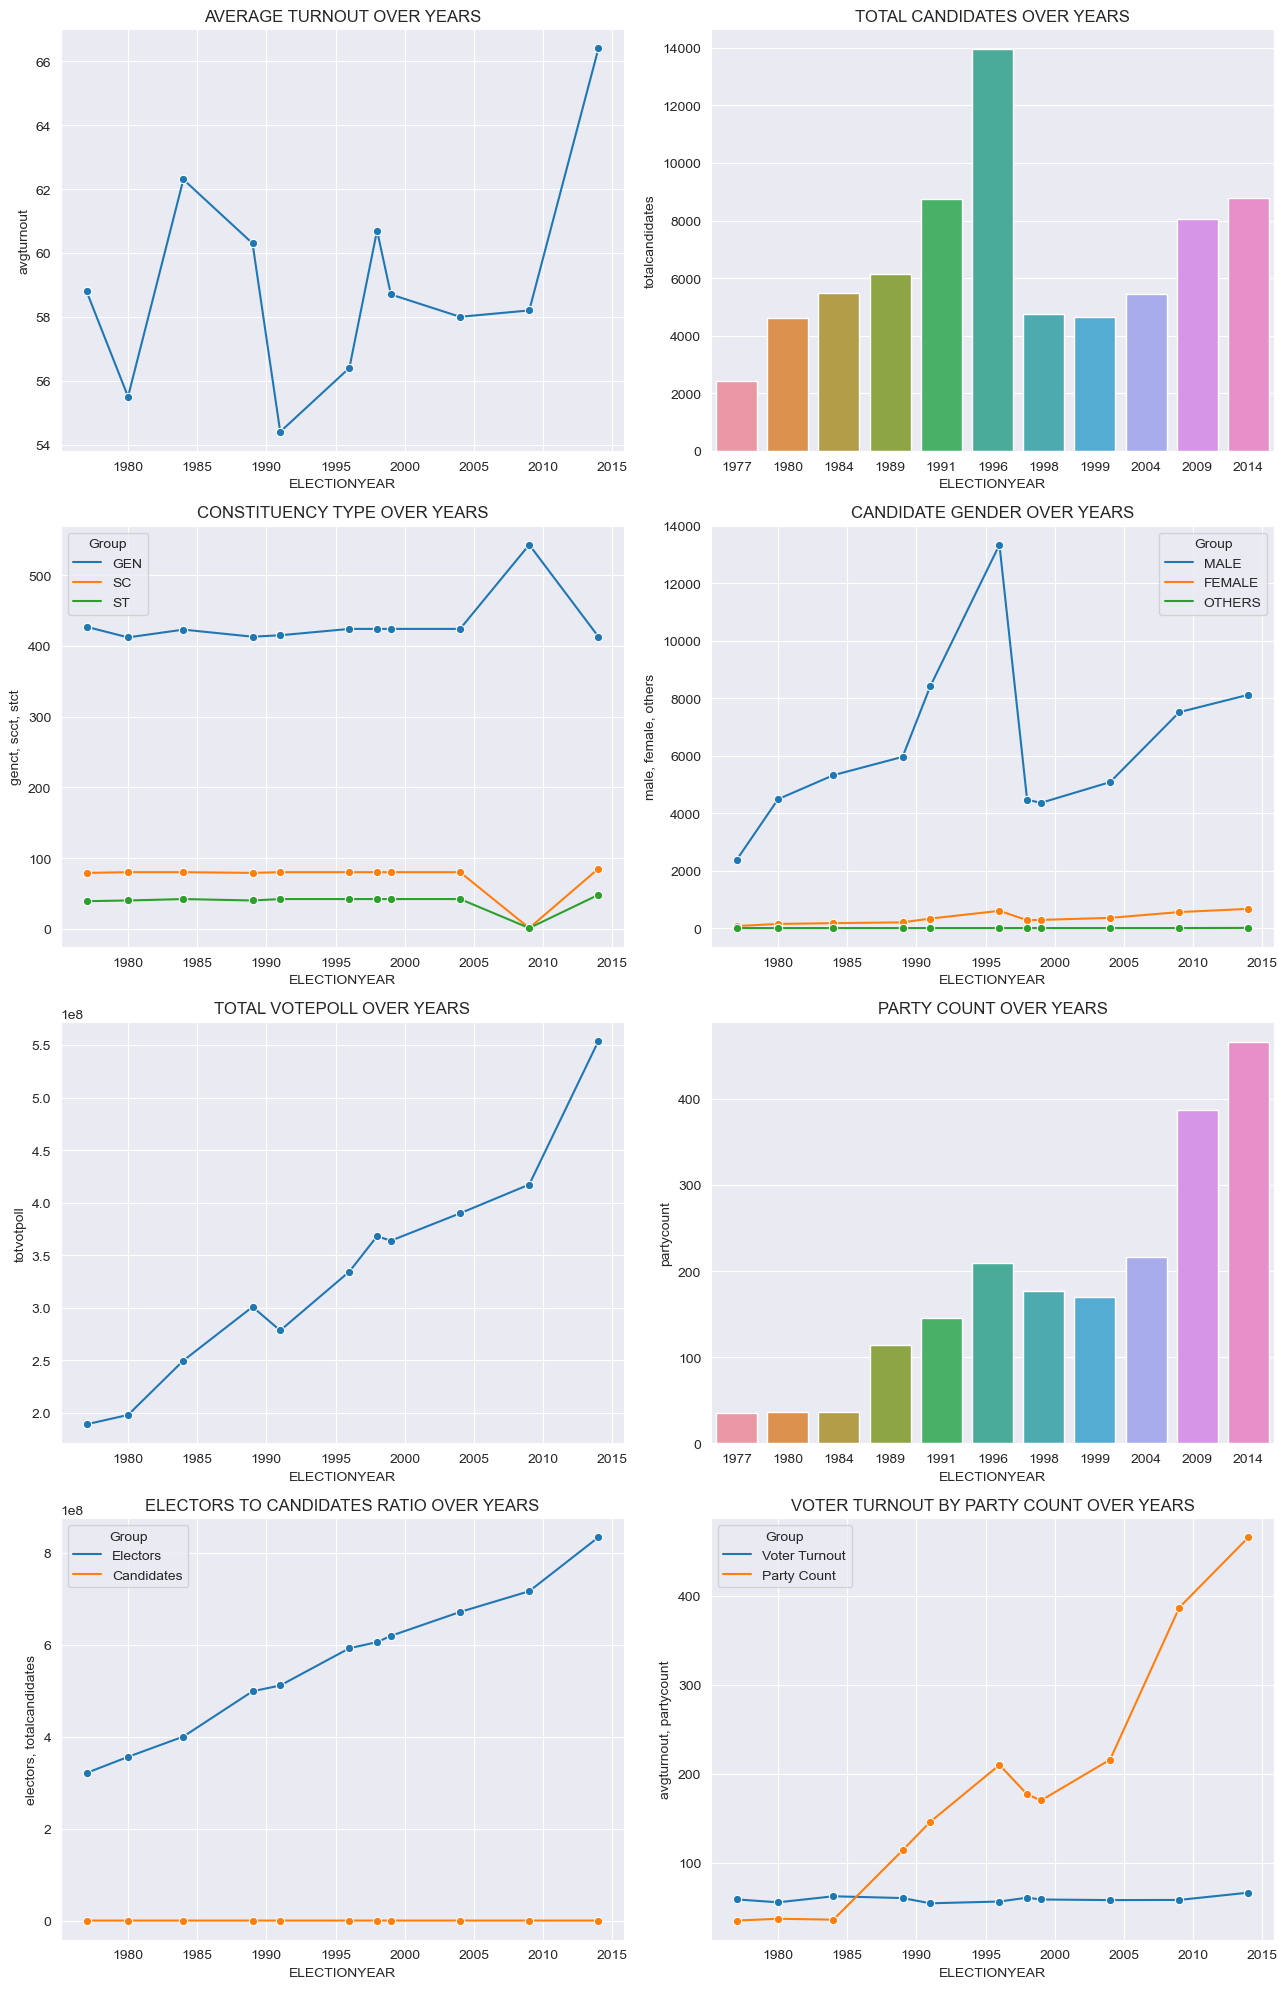

In [20]:
# Example usage
chartParams = {
    "chartData": [
        {
            "type": "line",
            "xCol": "electionyear",
            "yCol": ["avgturnout"],
            "chartTitle": "Average Turnout Over Years"
        },
        {
            "type": "bar",
            "xCol": "electionyear",
            "yCol": ["totalcandidates"],
            "chartTitle": "Total Candidates Over Years"
        },
        {
            "type": "line",
            "xCol": "electionyear",
            "yCol": ["genct","scct","stct"],
            "legend" : ["GEN","SC","ST"],
            "chartTitle": "Constituency Type Over Years"
        },
        {
            "type": "line",
            "xCol": "electionyear",
            "yCol": ["male","female","others"],
            "legend" : ["MALE","FEMALE","OTHERS"],
            "chartTitle": "Candidate Gender Over Years"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["totvotpoll"],
          "chartTitle": "Total Votepoll Over Years"
        },
        {
          "type": "bar",
          "xCol": "electionyear",
          "yCol": ["partycount"],
          "chartTitle": "Party Count Over Years"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["electors", "totalcandidates"],
          "legend": ["Electors", "Candidates"],
          "chartTitle": "Electors to Candidates Ratio Over Years"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["avgturnout", "partycount"],
          "legend": ["Voter Turnout", "Party Count"],
          "chartTitle": "Voter Turnout by Party Count Over Years"
        }
        
        
    ]
}

plotTwoCharts(df, chartParams)

#### **Average Turnout Over Years:**
- Voter turnout increased over the years, with the highest at 66.4% in 2014 and the lowest at 55.5% in 1980. This indicates improving voter participation over time.

#### **Total Candidates Over Years:**
- The number of candidates grew significantly, from 2,439 in 1977 to 8,794 in 2014. The increase reflects a growing political landscape and more diverse party participation.

#### **Constituency Type Over Years (GEN, SC, ST):**
- Constituency types (General, SC, ST) remained relatively stable, with slight changes, showing consistent representation of diverse communities in the electoral process.

#### **Candidate Gender Over Years:**
- Male candidates consistently dominated, but female candidates increased over time, especially in 2009 and 2014, indicating gradual progress towards gender equality in elections.

#### **Total Electors Over Years:**
- The number of electors grew steadily, reflecting population growth and increased voter registration across election years.

#### **Total Votepoll Over Years:**
- Total votes cast followed a steady rise, aligning with the increase in electors and indicating consistent voter engagement in elections.

#### **Party Count Over Years:**
- The number of political parties remained stable with gradual increases, showing that the political field has become more diverse over the years.

#### **Electors to Candidates Ratio Over Years:**
- The ratio of electors to candidates remained relatively balanced, showing consistent competition and engagement in the electoral process.

#### **Voter Turnout by Party Count Over Years:**
- Voter turnout has steadily increased, while party count also grew, suggesting that a larger number of political parties did not necessarily reduce voter engagement.


- **For this analysis, we selected the top 3 states based on the number and types of constituencies (General, SC, and ST). These states were chosen for their significant representation in the electoral process, providing insights into how constituency distribution affects election outcomes, voter turnout, and candidate participation. This selection ensures a comprehensive understanding of political engagement and social inclusion across diverse regions.**

In [7]:
stateQuery = '''
        
    SELECT 
    	nm.lksid ,
    	ls.loksabhastates ,
    	COUNT(DISTINCT pcid) AS count
    FROM 
    	nationalmaster nm
    LEFT JOIN 
    	loksabhastate ls ON nm.lksid = ls.lksid 
    GROUP BY 
    	nm.lksid ,
    	ls.loksabhastates 
    ORDER BY 
    	COUNT 
    DESC


'''
stateConstDF = fetch_data(stateQuery)
stateConstDF.head(3)

,lksid,loksabhastates,count
0,10139,Uttar Pradesh,323
1,10123,Maharashtra,153
2,1014,Bihar,148


In [27]:
def stateAnlaysis(stateID):

    constQuery = '''  
        WITH constYear AS (
        	SELECT 
        		electionyear ,
        		nm.pcid,
        		pc_name,
        		COUNT(cand_name) AS totalCandidates,
        		SUM(
        		CASE 
        			WHEN nm.cand_sex = 'M' THEN 1 ELSE 0 
        		END
        		) AS male,
        		SUM(
        		CASE 
        			WHEN nm.cand_sex = 'F' THEN 1 ELSE 0 
        		END
        		) AS female,
        		SUM(
        		CASE 
        			WHEN nm.cand_sex = 'O' THEN 1 ELSE 0 
        		END
        		) AS OTHERS,
        		ROUND(
        			  (
        			    CAST(SUM(totvotpoll) AS DECIMAL(15,2)) / 
        			    CAST(SUM(DISTINCT electors) AS DECIMAL(15,2))
        			  ) * 100, 1
        			) AS avgTurnout
        
        
        	FROM 
        		nationalmaster nm
        	LEFT JOIN 
        		lkconstituency lc
        	ON nm.pcid = lc.pcid
        	WHERE 
        		nm.lksid = {stateID}
        	GROUP BY 
        	electionyear ,
        	nm.pcid ,
        	pc_name
        ),
        constData AS (
        SELECT 
        	electionyear as ecyear ,
        	MAX(totalcandidates) AS maxCount,
        	(SELECT pc_name FROM constYear WHERE electionyear = cy.electionyear AND totalCandidates = MAX(cy.totalcandidates) LIMIT 1) AS maxconstName,
        	(SELECT pc_name FROM constYear WHERE electionyear = cy.electionyear AND totalCandidates = MIN(cy.totalcandidates) LIMIT 1) AS minconstName,
        	MIN(totalcandidates) AS minCount,
        	ROUND(AVG(totalcandidates)) AS avgCount,
        	(SELECT pc_name FROM constYear WHERE electionyear = cy.electionyear AND male = MAX(cy.male) LIMIT 1) AS maxMaleconstName,
        	(SELECT pc_name FROM constYear WHERE electionyear = cy.electionyear AND female = MAX(cy.female) LIMIT 1) AS maxFeMaleconstName,
        	ROUND(AVG(male)) AS avgMale,
        	ROUND(AVG(female)) AS avgFemale,
        	ROUND(AVG(avgTurnout)) AS avgTurnout
        FROM 
        	constYear AS cy
        GROUP BY 
        	electionyear
        ORDER BY 
        	electionYear
        ASC
        ),
        constFinal AS (
        SELECT 
        	nm.electionyear ,
        	COUNT( DISTINCT 
        			CASE 
        				WHEN lc.pc_type = 'GEN' THEN nm.pcid ELSE 0 
        			END
        	) AS genCT,
        	COUNT( DISTINCT 
        			CASE 
        				WHEN lc.pc_type = 'SC' THEN nm.pcid ELSE 0 
        			END
        	) AS scCT,
        	COUNT( DISTINCT
        			CASE 
        				WHEN lc.pc_type = 'ST' THEN nm.pcid ELSE 0 
        			END
        	) AS stCT,
        	COUNT (DISTINCT prid) AS partyCount
        FROM 
        	nationalmaster nm
        LEFT JOIN 
        	loksabhastate ls ON nm.lksid = ls.lksid 
        LEFT JOIN 
        	lkconstituency lc ON nm.pcid = lc.pcid 
        WHERE 
        	ls.lksid = {stateID}
        GROUP BY 
        	nm.electionyear 
        )
        SELECT 
        	*
        FROM 
        	constFinal cf 
        LEFT JOIN 
        	constData cd ON cf.electionyear = cd.ecyear	
    
    '''
    constDf = fetch_data(constQuery.format(stateID = stateID))
    print(constDf.head())

    chartParams = {
      "chartData": [
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["genct", "scct", "stct"],
          "legend": ["General", "SC", "ST"],
          "chartTitle": "Constituency Types Over Years"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["partycount"],
          "chartTitle": "Party Count Over Years"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["maxcount", "mincount"],
          "legend": ["Max Candidates", "Min Candidates"],
          "chartTitle": "Maximum and Minimum Candidates Per Constituency"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["avgcount"],
          "chartTitle": "Average Number of Candidates Over Years"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["avgmale", "avgfemale"],
          "legend": ["Average Male Candidates", "Average Female Candidates"],
          "chartTitle": "Average Male and Female Candidates Over Years"
        },
        {
          "type": "line",
          "xCol": "electionyear",
          "yCol": ["avgturnout"],
          "chartTitle": "Average Voter Turnout Over Years"
        }
      ]
    }
    # print(constDf.columns)
    plotTwoCharts(constDf, chartParams)
    

In [28]:

candidateQuery = '''  
    --- CANDIDATES ---

    SELECT 
    	nm.cand_name ,
    	nm.cand_sex ,
    	COUNT(*) AS totalContested,
    	COUNT (DISTINCT prid) AS partyCount,
    	COUNT (DISTINCT pcid) AS constContested,
    	SUM(totvotpoll) AS totalVoteReceived,
    	ROUND(
    		  (
    		    CAST(SUM(totvotpoll) AS DECIMAL(15,2)) / 
    		    CAST(SUM(DISTINCT electors) AS DECIMAL(15,2))
    		  ) * 100, 1
    		) AS voteReceived,
    	p.totalwon,
    	p.totallost
    	
    FROM 
    	nationalmaster nm
    LEFT JOIN 
    	(
    		SELECT 
    			cand_name ,
    			cand_sex ,
    			SUM(CASE WHEN rn = 1 THEN 1 ELSE 0 END ) AS totalWon,
    			SUM(CASE WHEN rn > 1 THEN 1 ELSE 0 END ) AS totalLost
    		FROM
    		(
    			SELECT 
    				*,
    				ROW_NUMBER ()  OVER (PARTITION BY electionyear, pcid ORDER BY totvotpoll DESC ) AS rn
    			FROM 
    				nationalmaster n 
    			WHERE lksid = {lksid}
    	) AS p
    		GROUP BY 
    			cand_name,
    			cand_sex
    			
    	)AS p 
    ON nm.cand_name = p.cand_name AND nm.cand_sex = p.cand_sex
    
    WHERE 
    	nm.lksid = {lksid}
    GROUP BY
    	nm.cand_name ,
    	nm.cand_sex ,
    	p.totalwon,
    	p.totallost
    
    ORDER BY 
    	totalVoteReceived
    DESC 


'''

partyQuery = '''  
    SELECT 
    	nm.prid ,
    	lp.partyname,
    	COUNT(DISTINCT lc.pcid ) AS totalCT,
    	COUNT(
    	DISTINCT 
    	CASE 
    		WHEN lc.pc_type = 'GEN' THEN nm.pcid ELSE 0 
    	END
    	) AS genCT,
    	COUNT(
    	DISTINCT 
    	CASE 
    		WHEN lc.pc_type = 'SC' THEN nm.pcid ELSE 0 
    	END
    	) AS scCT,
    	COUNT(
    	DISTINCT
    	CASE 
    		WHEN lc.pc_type = 'ST' THEN nm.pcid ELSE 0 
    	END
    	) AS stCT,
    	-- CANDIDATE --
    	COUNT(*) AS totalCandidates,
    	SUM(
    	CASE 
    		WHEN nm.cand_sex = 'M' THEN 1 ELSE 0 
    	END
    	) AS male,
    	SUM(
    	CASE 
    		WHEN nm.cand_sex = 'F' THEN 1 ELSE 0 
    	END
    	) AS female,
    	SUM(
    	CASE 
    		WHEN nm.cand_sex = 'O' THEN 1 ELSE 0 
    	END
    	) AS OTHERS,
    	SUM(totvotpoll) AS totalVoteReceived,
    	ROUND(
    		  (
    		    CAST(SUM(totvotpoll) AS DECIMAL(15,2)) / 
    		    CAST(SUM(DISTINCT electors) AS DECIMAL(15,2))
    		  ) * 100, 1
    		) AS voteReceived,
    	p.totalwon,
    	p.totallost
    FROM 
    	nationalmaster nm
    LEFT JOIN lkparty lp
    ON nm.prid = lp.prid
    LEFT JOIN lkconstituency lc
    ON nm.pcid = lc.pcid 
    LEFT JOIN 
    	(
    		SELECT 
    			prid,
    			SUM(CASE WHEN rn = 1 THEN 1 ELSE 0 END ) AS totalWon,
    			SUM(CASE WHEN rn > 1 THEN 1 ELSE 0 END ) AS totalLost
    		FROM
    		(
    			SELECT 
    				*,
    				ROW_NUMBER ()  OVER (PARTITION BY electionyear, pcid ORDER BY totvotpoll DESC ) AS rn
    			FROM 
    				nationalmaster n 
    			WHERE lksid =  {lksid}
    	) AS p
    		GROUP BY 
    			prid
    			
    	)AS p 
    ON nm.prid = p.prid 
    
    WHERE nm.lksid = {lksid}
    
    GROUP BY 
    nm.prid ,
    lp.partyname,
    p.totalwon,
    p.totallost
    
    ORDER BY 
    totalVoteReceived
    DESC 

'''


In [39]:
def constCandAnalysis(stateID):
    """
    Analyzes candidate and party data for a given state in an election,
    providing insights into gender representation, performance, and overall
    electoral trends. Generates a comprehensive and context-rich report.

    Args:
    - stateID (str): Identifier for the state to fetch election data.
    """
    # Format the queries with the provided stateID
    formatted_candidate_query = candidateQuery.format(lksid=stateID)
    formatted_party_query = partyQuery.format(lksid=stateID)

    # Fetch data from the database
    cand_df = fetch_data(formatted_candidate_query)
    party_df = fetch_data(formatted_party_query)

    # Analyze candidate data
    def analyze_candidates(cand_df):
        """
        Analyzes individual candidate-level data to assess gender representation,
        performance metrics, and voter engagement.
        """
        total_male = cand_df[cand_df['cand_sex'] == 'M'].shape[0]
        total_female = cand_df[cand_df['cand_sex'] == 'F'].shape[0]
        total_wins = cand_df['totalwon'].sum()
        total_losses = cand_df['totallost'].sum()
        avg_vote_percentage = cand_df['votereceived'].mean()

        analysis = {
            'total_male_candidates': total_male,
            'total_female_candidates': total_female,
            'total_wins': total_wins,
            'total_losses': total_losses,
            'average_vote_percentage': avg_vote_percentage
        }

        return analysis

    # Analyze party data
    def analyze_parties(party_df):
        """
        Analyzes party-level data to understand participation trends,
        gender distribution across parties, and electoral success metrics.
        """
        total_parties = party_df.shape[0]
        total_male_candidates_party = party_df['male'].sum()
        total_female_candidates_party = party_df['female'].sum()
        avg_vote_received = party_df['votereceived'].mean()
        total_won = party_df['totalwon'].sum()
        total_lost = party_df['totallost'].sum()

        analysis = {
            'total_parties': total_parties,
            'total_male_candidates_party': total_male_candidates_party,
            'total_female_candidates_party': total_female_candidates_party,
            'average_vote_received': avg_vote_received,
            'total_won': total_won,
            'total_lost': total_lost
        }

        return analysis

    # Run analyses
    cand_analysis = analyze_candidates(cand_df)
    party_analysis = analyze_parties(party_df)

    # Generate the report
    report = f"""
    --- Election Analysis Report for State ID {stateID} ---

    Candidate Analysis:
    -------------------
    1. **Total Male Candidates**: {cand_analysis['total_male_candidates']}
       - Indicates the participation of male candidates. A higher number may reflect societal norms or biases favoring male participation.

    2. **Total Female Candidates**: {cand_analysis['total_female_candidates']}
       - Highlights gender diversity in the election. Analyzing this can provide insights into inclusivity and representation in politics.

    3. **Total Wins**: {cand_analysis['total_wins']}
       - Represents the number of successful candidates. Understanding who wins can reveal voting trends and preferences.

    4. **Total Losses**: {cand_analysis['total_losses']}
       - Shows the competition level. A high loss count may indicate tightly contested elections or an influx of new participants.

    5. **Average Vote Percentage**: {cand_analysis['average_vote_percentage']:.2f}%
       - Reflects voter engagement and candidate appeal. This metric helps identify how votes are distributed across candidates.

    Party Analysis:
    ---------------
    1. **Total Number of Parties**: {party_analysis['total_parties']}
       - Indicates the diversity of political representation. A higher number suggests competitive and multi-party participation.

    2. **Total Male Candidates across Parties**: {party_analysis['total_male_candidates_party']}
       - Provides a broader perspective on gender representation at the party level, complementing the candidate analysis.

    3. **Total Female Candidates across Parties**: {party_analysis['total_female_candidates_party']}
       - Highlights the emphasis parties place on gender inclusivity in their candidate selection.

    4. **Average Vote Received across Parties**: {party_analysis['average_vote_received']:.2f}%
       - Indicates how well parties perform in attracting voter support. This is critical for understanding party-level dynamics.

    5. **Total Wins across Parties**: {party_analysis['total_won']}
       - Shows the success rate of parties. Helps identify dominant and emerging political forces.

    6. **Total Losses across Parties**: {party_analysis['total_lost']}
       - Indicates competition intensity among parties. A high loss count may reflect a highly contested election.

    --- Summary ---
    This analysis provides a detailed understanding of gender representation, electoral competition, and the dynamics of candidate and party performance. It helps stakeholders identify trends, assess inclusivity, and strategize for future elections.

    """

    # Display the report
    print(report)


# **UTTAR PRADESH**

   electionyear  genct  scct  stct  partycount  ecyear  maxcount maxconstname  \
0          1977     68    19     1          11    1977        14    Moradabad   
1          1980     68    19     1          15    1980        31        Hapur   
2          1984     68    19     1          11    1984        40      Lucknow   
3          1989     68    19     1          28    1989        47       Amethi   
4          1991     67    19     1          41    1991        48    Allahabad   

   minconstname  mincount  avgcount maxmaleconstname maxfemaleconstname  \
0       Misrikh         2       5.0        Moradabad              Aonla   
1  Mohanlalganj         4      12.0            Hapur            Aligarh   
2       Misrikh         6      15.0           Kanpur            Lucknow   
3       Misrikh         4      13.0           Amethi             Bijnor   
4       Misrikh         7      19.0           Etawah             Kanpur   

   avgmale  avgfemale  avgturnout  
0      5.0        0.0     

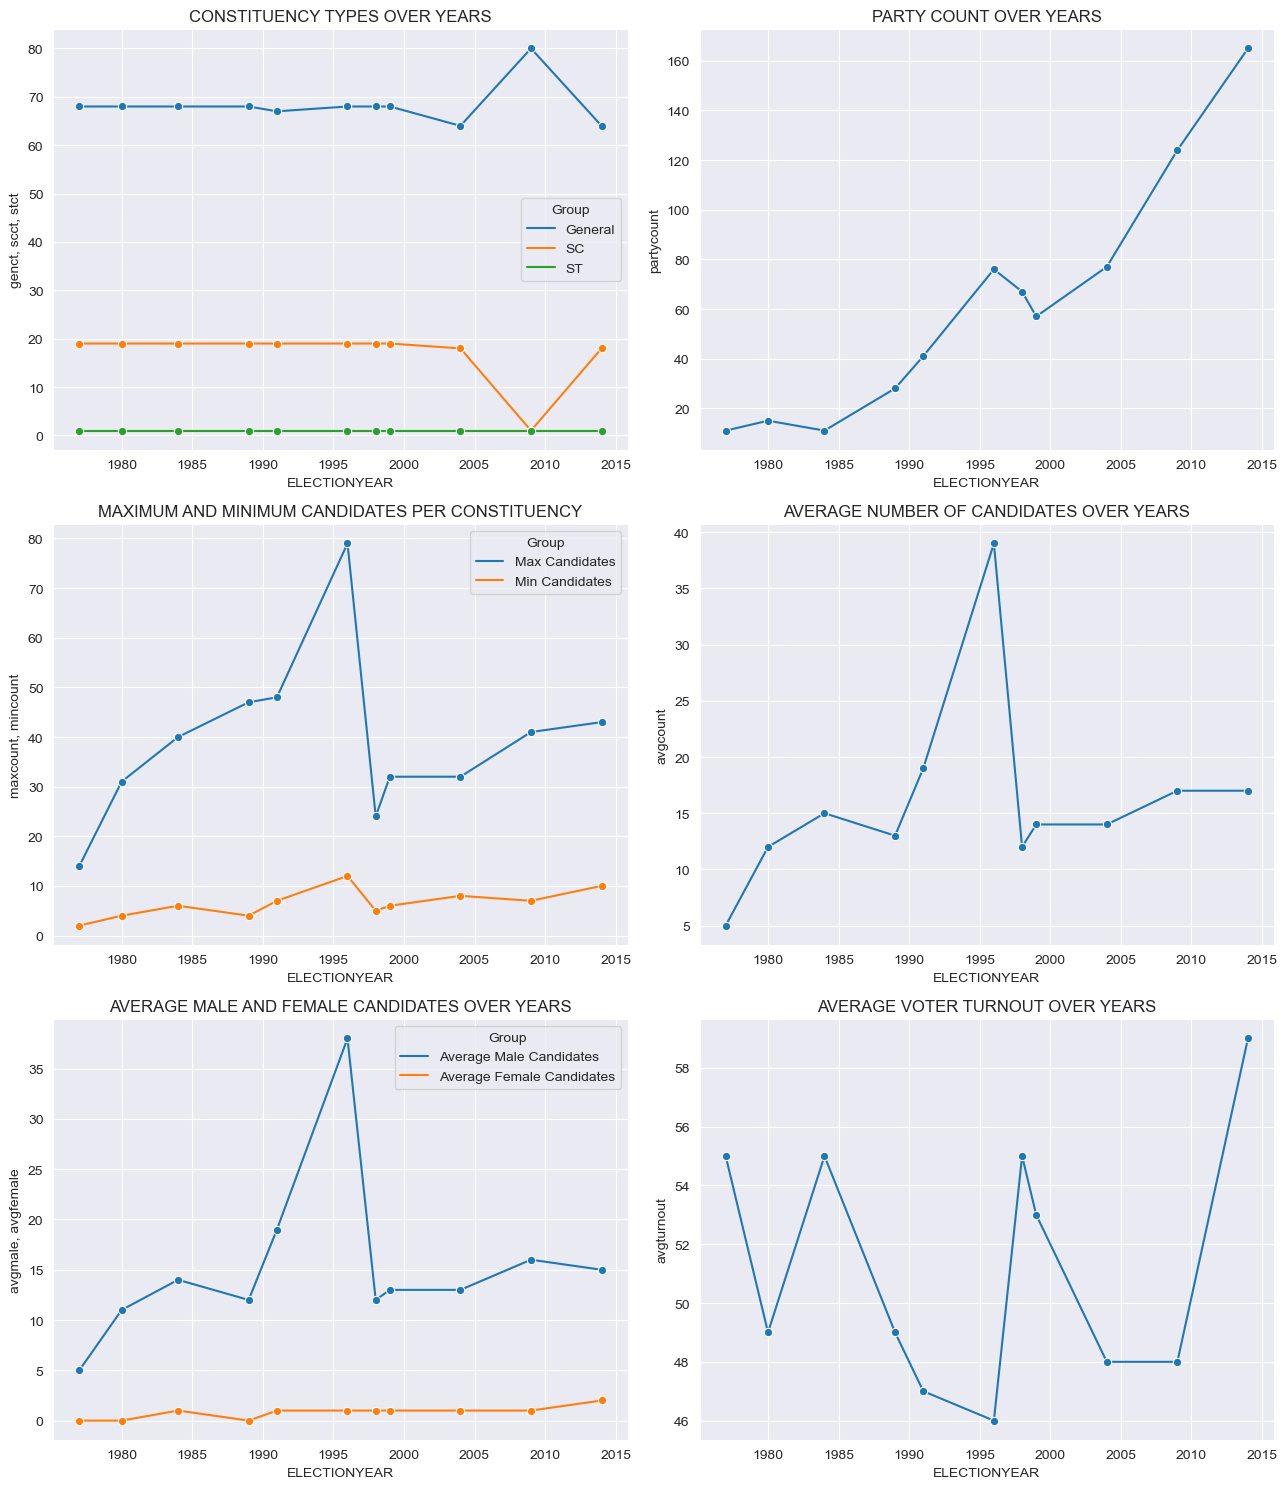

In [40]:
stateAnlaysis(10139)

In [41]:
constCandAnalysis(10139)


    --- Election Analysis Report for State ID 10139 ---

    Candidate Analysis:
    -------------------
    1. **Total Male Candidates**: 9638
       - Indicates the participation of male candidates. A higher number may reflect societal norms or biases favoring male participation.

    2. **Total Female Candidates**: 568
       - Highlights gender diversity in the election. Analyzing this can provide insights into inclusivity and representation in politics.

    3. **Total Wins**: 919
       - Represents the number of successful candidates. Understanding who wins can reveal voting trends and preferences.

    4. **Total Losses**: 13872
       - Shows the competition level. A high loss count may indicate tightly contested elections or an influx of new participants.

    5. **Average Vote Percentage**: 2.85%
       - Reflects voter engagement and candidate appeal. This metric helps identify how votes are distributed across candidates.

    Party Analysis:
    ---------------
    1. **T

# **MAHARASHTRA**

   electionyear  genct  scct  stct  partycount  ecyear  maxcount  \
0          1977     43     4     4           8    1977        14   
1          1980     42     4     5          13    1980        23   
2          1984     42     4     5          11    1984        25   
3          1989     42     4     5          24    1989        29   
4          1991     42     4     5          33    1991        46   

   maxconstname minconstname  mincount  avgcount maxmaleconstname  \
0  Bombay South      Rajapur         2       4.0     Bombay South   
1        Nagpur       Sangli         2       9.0           Nagpur   
2        Nagpur       Sangli         2      10.0           Nagpur   
3        Nagpur     Malegaon         3      12.0           Nagpur   
4        Nagpur      Rajapur         5      18.0           Nagpur   

     maxfemaleconstname  avgmale  avgfemale  avgturnout  
0  Bombay North Central      4.0        0.0        59.0  
1  Bombay North Central      8.0        0.0        55.0  
2 

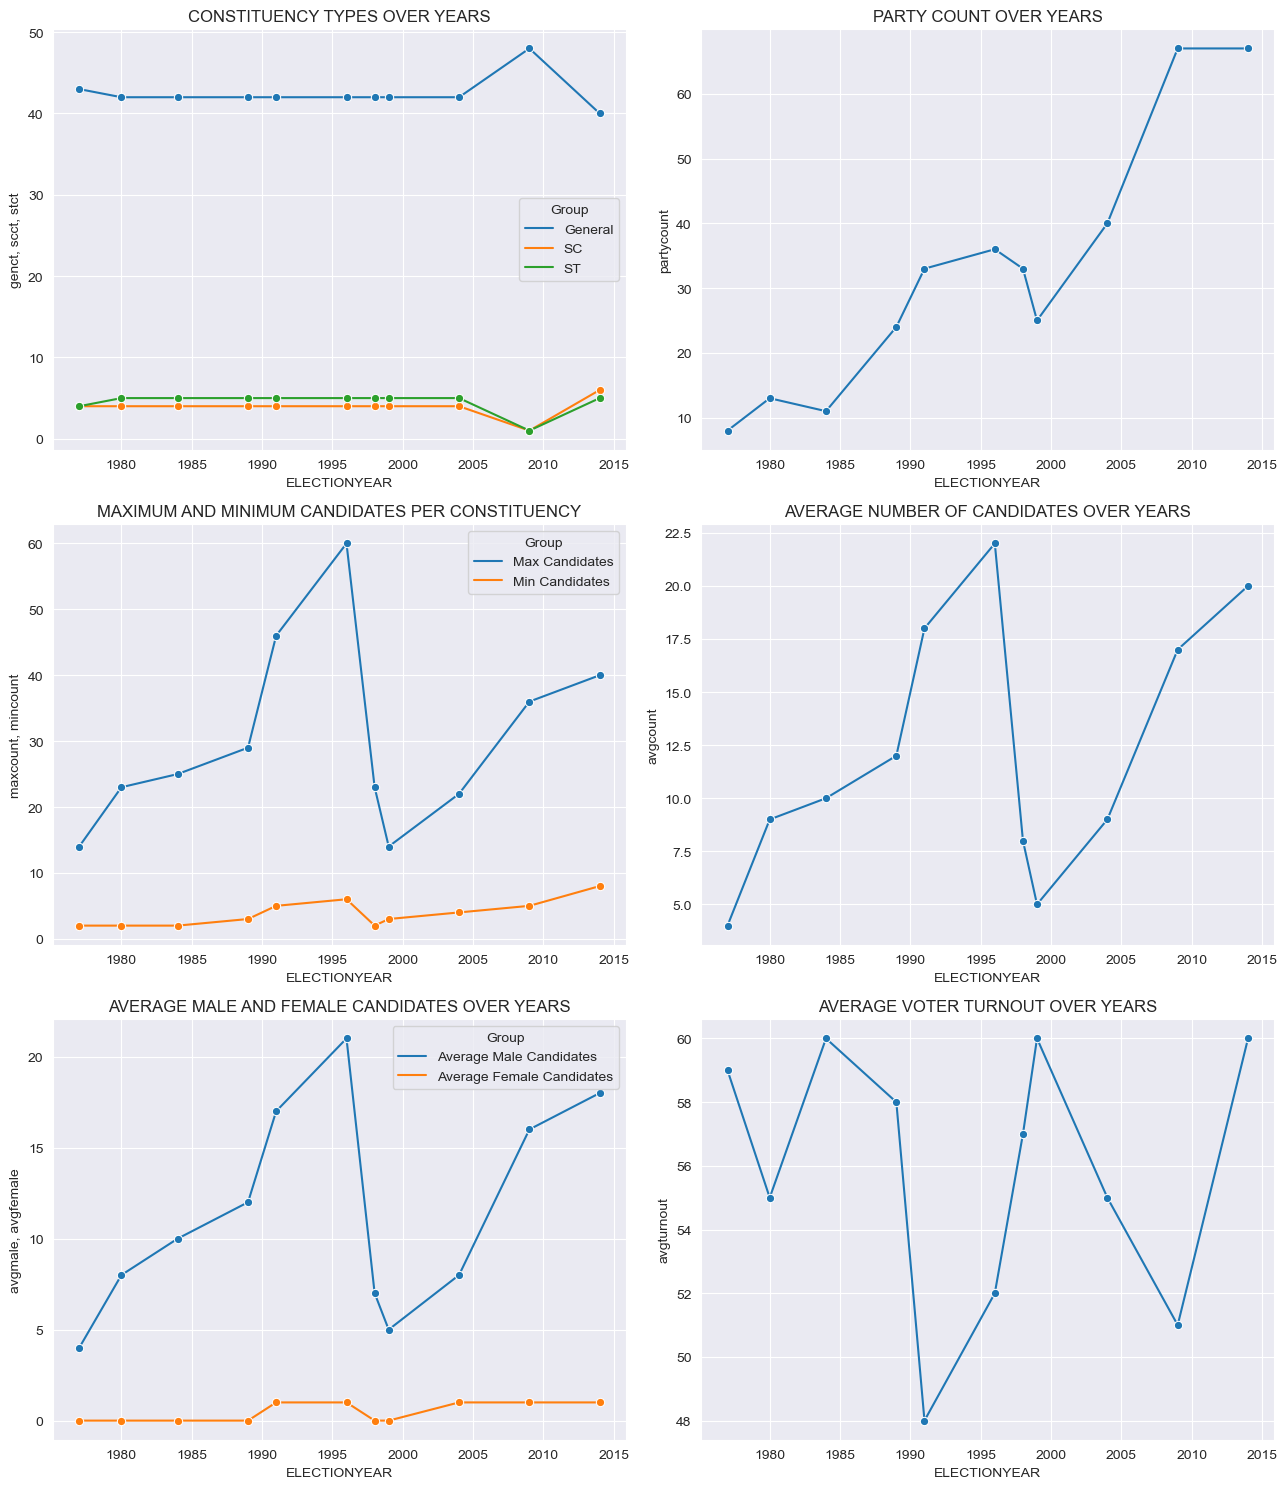

In [42]:
stateAnlaysis(10123)

In [43]:
constCandAnalysis(10123)


    --- Election Analysis Report for State ID 10123 ---

    Candidate Analysis:
    -------------------
    1. **Total Male Candidates**: 5533
       - Indicates the participation of male candidates. A higher number may reflect societal norms or biases favoring male participation.

    2. **Total Female Candidates**: 306
       - Highlights gender diversity in the election. Analyzing this can provide insights into inclusivity and representation in politics.

    3. **Total Wins**: 528
       - Represents the number of successful candidates. Understanding who wins can reveal voting trends and preferences.

    4. **Total Losses**: 5930
       - Shows the competition level. A high loss count may indicate tightly contested elections or an influx of new participants.

    5. **Average Vote Percentage**: 3.85%
       - Reflects voter engagement and candidate appeal. This metric helps identify how votes are distributed across candidates.

    Party Analysis:
    ---------------
    1. **To

# **BIHAR**

   electionyear  genct  scct  stct  partycount  ecyear  maxcount maxconstname  \
0          1977     42     9     6          12    1977        13      Dhanbad   
1          1980     42     9     6          14    1980        30        Patna   
2          1984     42     9     6          11    1984        26        Arrah   
3          1989     42     9     6          28    1989        33        Patna   
4          1991     40     9     6          33    1991        46  Muzaffarpur   

  minconstname  mincount  avgcount maxmaleconstname maxfemaleconstname  \
0    Bhagalpur         2       6.0          Dhanbad            Palamau   
1       Bagaha         3      11.0            Patna           Khagaria   
2    Begusarai         4      13.0            Arrah           Vaishali   
3        Banka         4      13.0            Patna           Vaishali   
4     Motihari        11      23.0      Muzaffarpur           Vaishali   

   avgmale  avgfemale  avgturnout  
0      6.0        0.0        59.

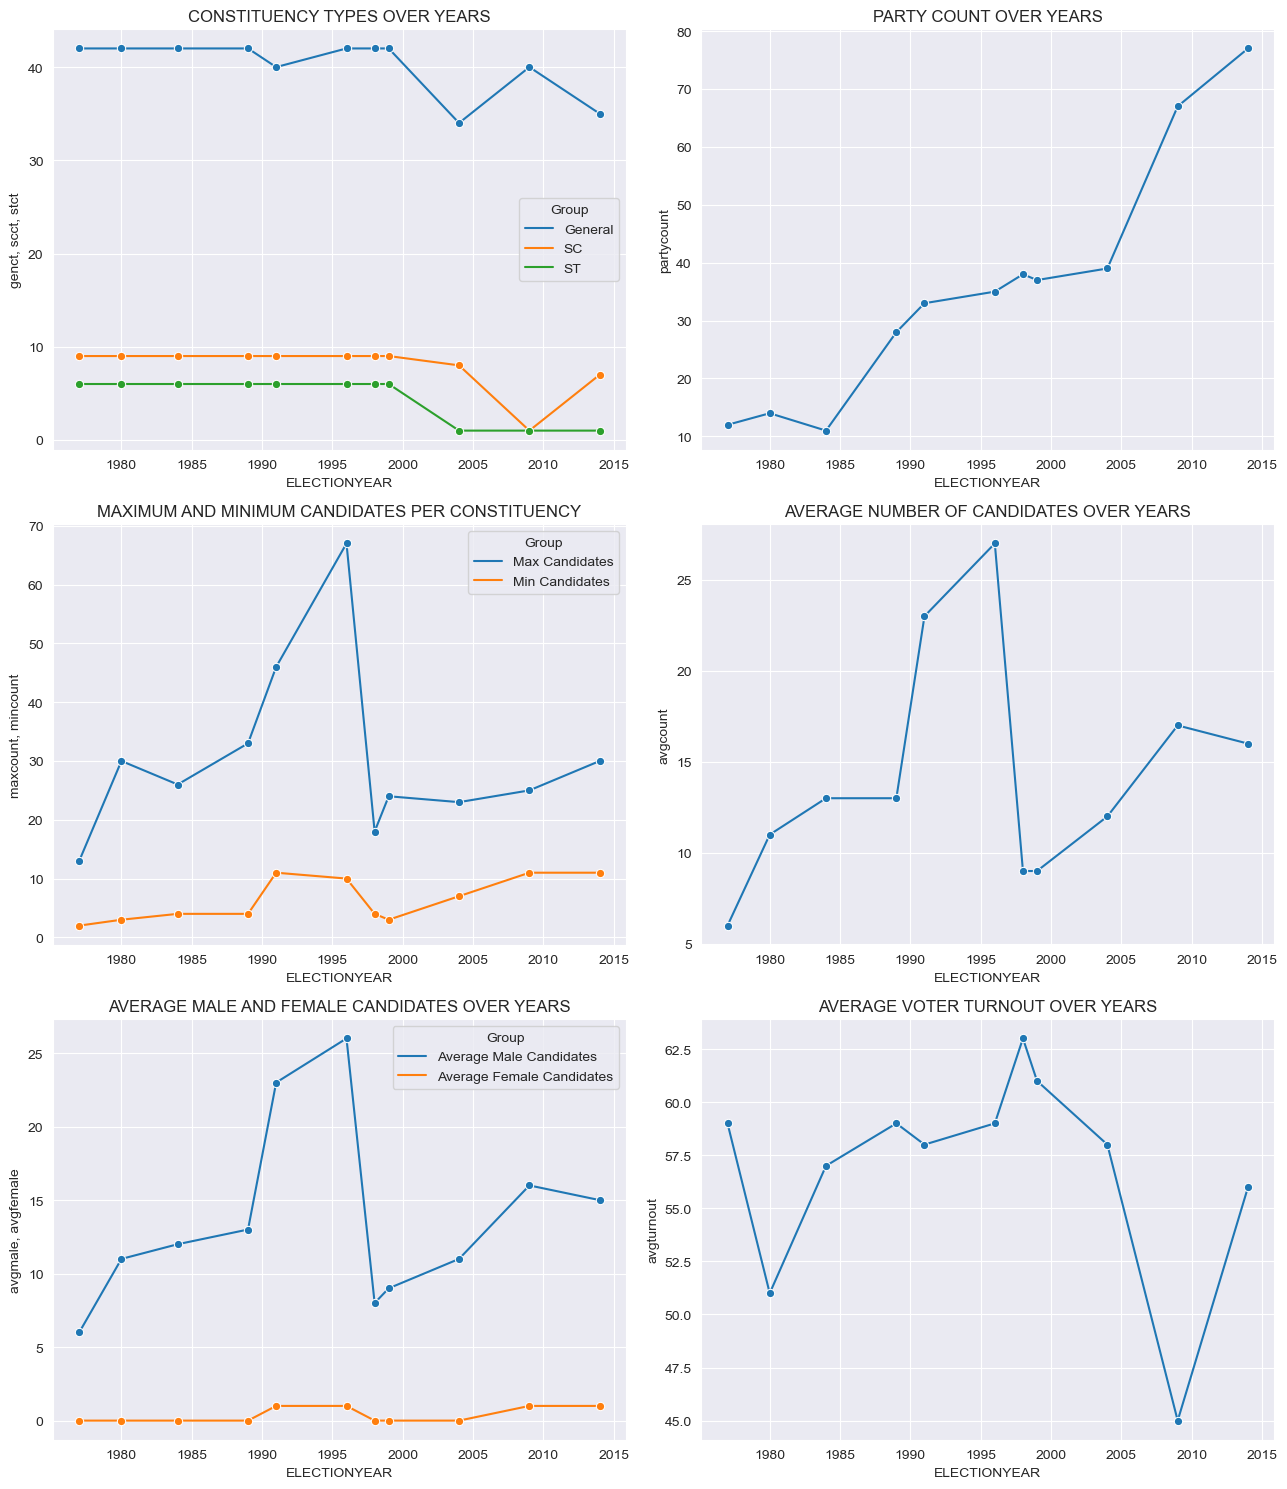

In [44]:
stateAnlaysis(1014)

In [45]:
constCandAnalysis(1014)


    --- Election Analysis Report for State ID 1014 ---

    Candidate Analysis:
    -------------------
    1. **Total Male Candidates**: 5884
       - Indicates the participation of male candidates. A higher number may reflect societal norms or biases favoring male participation.

    2. **Total Female Candidates**: 231
       - Highlights gender diversity in the election. Analyzing this can provide insights into inclusivity and representation in politics.

    3. **Total Wins**: 550
       - Represents the number of successful candidates. Understanding who wins can reveal voting trends and preferences.

    4. **Total Losses**: 7177
       - Shows the competition level. A high loss count may indicate tightly contested elections or an influx of new participants.

    5. **Average Vote Percentage**: 3.05%
       - Reflects voter engagement and candidate appeal. This metric helps identify how votes are distributed across candidates.

    Party Analysis:
    ---------------
    1. **Tot